# PBO learnt on several iterations and one weigth one the car on hill environment

## Define parameters

In [31]:
%load_ext autoreload
%autoreload 2

import numpy as np
import jax
import jax.numpy as jnp

# keys
seed = 0
key = jax.random.PRNGKey(seed)
shuffle_key, q_network_key, random_weights_key, pbo_network_key = jax.random.split(key, 4)

# Sample collection
n_states_x = 20
n_states_v = 20
n_actions = 2
n_samples = n_states_x * n_states_v * n_actions
gamma = 0.9

# # Weights collection
n_weights = 500

# # Trainings
layers_dimension = (20, 20)
max_bellman_iterations = 10
batch_size_samples = n_samples // 4

# ## Linear PBO
fitting_steps = 4
training_steps = 10
batch_size_weights = n_weights
learning_rate = {"first": 0.0005, "last": 0.00005, "duration": fitting_steps * n_samples // batch_size_samples}

# ## Q-learning
fitting_steps_q = fitting_steps * training_steps
learning_rate_q = {"first": 0.001, "last": 0.0005, "duration": fitting_steps_q * n_samples // batch_size_samples}

# # Visualisation of errors and performances
max_bellman_iterations_validation = max_bellman_iterations + 20
horizon = 50

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Define environment

In [2]:
from pbo.environment.car_on_hill import CarOnHillEnv

max_pos = 1.0
max_velocity = 3.0

states_x = jnp.linspace(-max_pos, max_pos, n_states_x)
boxes_x_size = (2 * max_pos) / (n_states_x - 1)
states_x_boxes = (np.linspace(-max_pos, max_pos + boxes_x_size, n_states_x + 1) - boxes_x_size / 2)
states_v = jnp.linspace(-max_velocity, max_velocity, n_states_v)
boxes_v_size = (2 * max_velocity) / (n_states_v - 1)
states_v_boxes = (np.linspace(-max_velocity, max_velocity + boxes_v_size, n_states_v + 1) - boxes_v_size / 2)


env = CarOnHillEnv(max_pos, max_velocity, gamma)

## Collect samples

### Samples on the mesh

In [3]:
from pbo.sample_collection.replay_buffer import ReplayBuffer


replay_buffer = ReplayBuffer()

n_samples = n_states_x * n_states_v * n_actions

for state_x in states_x:
    for state_v in states_v:
        state = jnp.array([state_x, state_v])
        
        for action in jnp.arange(n_actions):
            env.reset(state)
            next_state, reward, _, _ = env.step(jnp.array([action]))

            replay_buffer.add(state, jnp.array([action]), reward, next_state)

replay_buffer.cast_to_jax_array()

### Visualize samples

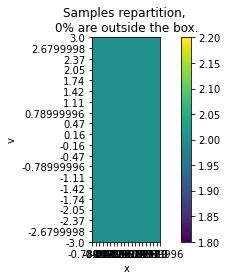

In [4]:
from pbo.sample_collection.count_samples import count_samples
from pbo.utils.two_dimesions_mesh import TwoDimesionsMesh


samples_count, n_outside_boxes = count_samples(replay_buffer.states[:, 0], replay_buffer.states[:, 1], states_x_boxes, states_v_boxes)
samples_visu_mesh = TwoDimesionsMesh(states_x, states_v, sleeping_time=0)

samples_visu_mesh.set_values(samples_count, zeros_to_nan=True)
samples_visu_mesh.show(
    f"Samples repartition, \n{int(100 * n_outside_boxes / n_samples)}% are outside the box.", xlabel="x", ylabel="v"
)

## Optimal Q function

In [5]:
# optimal_v = env.optimal_v_mesh(states_x, states_v, max_steps=10)

# q_visu_mesh = TwoDimesionsMesh(states_x, states_v, sleeping_time=0)

# q_visu_mesh.set_values(optimal_v)
# q_visu_mesh.show("Optimal v function", xlabel="x", ylabel="v")

## Train Q with Fitted-Q

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

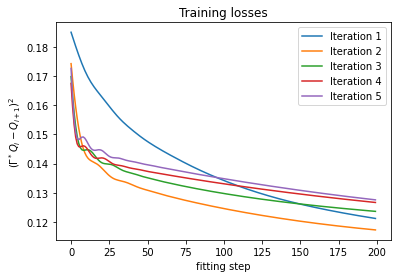

In [6]:
import matplotlib.pyplot as plt 
from tqdm.notebook import tqdm

from pbo.sample_collection.dataloader import SampleDataLoader
from pbo.networks.learnable_q import FullyConnectedQ


data_loader_samples = SampleDataLoader(replay_buffer, batch_size_samples, shuffle_key)
q = FullyConnectedQ(
    state_dim=2,
    action_dim=1,
    continuous_actions=False,
    n_actions_on_max=n_actions,
    action_range_on_max=None,
    gamma=gamma,
    network_key=q_network_key,
    random_weights_range=None,
    random_weights_key=random_weights_key,
    learning_rate=learning_rate_q,
    layers_dimension=layers_dimension,
    zero_initializer=True,
)
validation_initial_weight = q.to_weights(q.params)

l2_losses = np.zeros((max_bellman_iterations, fitting_steps_q))

for bellman_iteration in tqdm(range(max_bellman_iterations)):
    params_target = q.params
    q.reset_optimizer()

    for step in tqdm(range(fitting_steps_q), leave=False):
        cumulative_l2_loss = 0
        
        data_loader_samples.shuffle()
        for batch_samples in data_loader_samples:
            q.params, q.optimizer_state, l2_loss = q.learn_on_batch(q.params, params_target, q.optimizer_state, batch_samples)
            cumulative_l2_loss += l2_loss

        l2_losses[bellman_iteration, step] = cumulative_l2_loss



for bellman_iteration in range(max_bellman_iterations):
    plt.plot(l2_losses[bellman_iteration], label=f"Iteration {bellman_iteration + 1}")

plt.legend()
plt.xlabel("fitting step")
plt.ylabel(r"$(\Gamma^*Q_i - Q_{i +  1})^2$")
plt.title("Training losses")
plt.show()

In [7]:
env.simulate(q, horizon, jnp.array([-0.5, 0]))

[-0.5  0. ]
[-0.08628818]
[-0.08109996]

[-0.4803309  0.3866922]
[-0.05683526]
[-0.03228384]

[-0.4254183  0.690585 ]
[-0.06118373]
[-0.00042003]

[-0.34757635  0.83584267]
[-0.04429268]
[0.04344343]

[-0.2641553   0.80664194]
[-5.5139884e-05]
[0.09902559]

[-0.19029287  0.65616035]
[0.04119655]
[0.14246483]

[-0.13487127  0.44623253]
[0.05721693]
[0.16364485]

[-0.10178459  0.2134663 ]
[0.04634076]
[0.16397873]

[-0.09239412 -0.02605632]
[0.01511377]
[0.14327392]

[-0.10697368 -0.26488298]
[-0.03717101]
[0.09711606]

[-0.14507785 -0.494572  ]
[-0.11536702]
[0.02366389]

[-0.20496078 -0.69564986]
[-0.21022812]
[-0.06751394]

[-0.28187156 -0.825685  ]
[-0.28637874]
[-0.15029567]

[-0.3655518 -0.8199489]
[-0.29797074]
[-0.19049095]

[-0.43982083 -0.63601804]
[-0.23672016]
[-0.17620684]

[-0.48786    -0.30687606]
[-0.14571998]
[-0.12752694]

[-0.49905953  0.08663929]
[-0.07492007]
[-0.0687765]

[-0.47111082  0.4626276 ]
[-0.05698192]
[-0.02469759]

[-0.4099146   0.73743236]
[-0.0605328]
[

DeviceArray([False], dtype=bool)

## Collect weights

In [8]:
from pbo.weights_collection.weights_buffer import WeightsBuffer


weights_buffer = WeightsBuffer()

# Add initial validation weights
weights_buffer.add(validation_initial_weight)

# Add randow weights
q = FullyConnectedQ(
    state_dim=2,
    action_dim=1,
    continuous_actions=False,
    n_actions_on_max=n_actions,
    action_range_on_max=None,
    gamma=gamma,
    network_key=q_network_key,
    random_weights_range=None,
    random_weights_key=random_weights_key,
    learning_rate=None,
    layers_dimension=layers_dimension,
    zero_initializer=False,
)

while len(weights_buffer) < n_weights:
    weights = q.random_init_weights()
    weights_buffer.add(weights)

weights_buffer.cast_to_jax_array()

## Train non linear PBO

In [9]:
# from tqdm.notebook import tqdm

# from pbo.sample_collection.dataloader import SampleDataLoader
# from pbo.weights_collection.dataloader import WeightsDataLoader
# from pbo.networks.learnable_pbo import TabularPBO


# data_loader_samples = SampleDataLoader(replay_buffer, batch_size_samples, shuffle_key)
# data_loader_weights = WeightsDataLoader(weights_buffer, batch_size_weights, shuffle_key)
# pbo_tabular = TabularPBO(q, max_bellman_iterations, add_infinity, pbo_network_key, learning_rate, n_actions)
# importance_iteration = jnp.ones(max_bellman_iterations + 1)
# importance_iteration = importance_iteration.at[-1].set(0)

# for _ in tqdm(range(training_steps)):
#     params_target = pbo_tabular.params

#     for _ in range(fitting_steps):
#         data_loader_weights.shuffle()
#         for batch_weights in data_loader_weights:
#             data_loader_samples.shuffle()
#             for batch_samples in data_loader_samples:
#                 pbo_tabular.params, pbo_tabular.optimizer_state, _ = pbo_tabular.learn_on_batch(
#                     pbo_tabular.params, params_target, pbo_tabular.optimizer_state, batch_weights, batch_samples, importance_iteration
#                 )

# training_losses_tabular = np.zeros(max_bellman_iterations_validation)
# validation_losses_tabular = np.zeros(max_bellman_iterations_validation)
# absording_probabilities_tabular = np.zeros((max_bellman_iterations_validation, horizon))

# batch_iterated_weights = validation_initial_weight.reshape((1, -1))
# for bellman_iteration in range(max_bellman_iterations_validation):
#     q_i = q.discretize(batch_iterated_weights, states, actions)[0]
#     batch_iterated_weights = pbo_tabular(pbo_tabular.params, batch_iterated_weights)
#     q_i_plus_1 = q.discretize(batch_iterated_weights, states, actions)[0]
#     policy_q = q_i_plus_1.argmax(axis=1)

#     training_losses_tabular[bellman_iteration] = jnp.abs(env.apply_bellman_operator(q_i) - q_i_plus_1).mean()
#     validation_losses_tabular[bellman_iteration] = jnp.abs(optimal_q - q_i_plus_1).mean()
#     absording_probabilities_tabular[bellman_iteration] = env.absorbing_probability(policy_q, horizon)


## Train linear PBO

  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

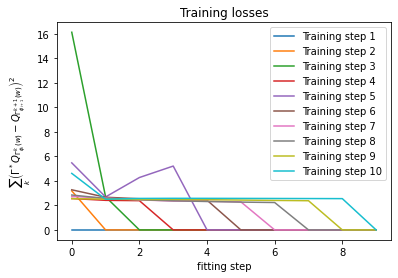

In [37]:
from tqdm.notebook import tqdm

from pbo.sample_collection.dataloader import SampleDataLoader
from pbo.weights_collection.dataloader import WeightsDataLoader
from pbo.networks.learnable_pbo import LinearPBO


data_loader_samples = SampleDataLoader(replay_buffer, batch_size_samples, shuffle_key)
data_loader_weights = WeightsDataLoader(weights_buffer, batch_size_weights, shuffle_key)
pbo = LinearPBO(q, max_bellman_iterations, True, pbo_network_key, learning_rate)  # add_infinity == True
importance_iteration = jnp.ones(max_bellman_iterations + 1)
# importance_iteration = importance_iteration.at[-1].set(0)

l2_losses = np.zeros((training_steps, training_steps + 1))

for training_step in tqdm(range(training_steps)):
    params_target = pbo.params
    pbo.reset_optimizer()

    for fitting_step in tqdm(range(training_step + 1), leave=False):
        cumulative_l2_loss = 0

        data_loader_weights.shuffle()
        for batch_weights in data_loader_weights:
            data_loader_samples.shuffle()
            for batch_samples in data_loader_samples:
                pbo.params, pbo.optimizer_state, l2_loss = pbo.learn_on_batch(
                    pbo.params, params_target, pbo.optimizer_state, batch_weights, batch_samples, importance_iteration
                )
                cumulative_l2_loss += l2_loss
        
        l2_losses[training_step, fitting_step] = cumulative_l2_loss


for training_step in range(0, training_steps):
    plt.plot(l2_losses[training_step], label=f"Training step {training_step + 1}")

plt.legend()
plt.xlabel("fitting step")
plt.ylabel(r"$\sum_{k} \left(\Gamma^*Q_{\Gamma_{\phi_i}^k(w)} - Q_{\Gamma_{\phi_{i + 1}}^{k + 1}(w)} \right)^2$")
plt.title("Training losses")
plt.show()

In [38]:
l2_losses

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 3.18892193,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [16.14351845,  2.7064352 ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 2.5636785 ,  2.41587758,  2.38887143,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 5.47698593,  2.69439244,  4.27882051,  5.21411991,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 3.27674365,  2.66794848,  2.5458777 ,  2.45292306,  2.42897868,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 2.73283219,  2.60177064,  2.45334053,  2.35612822,  2.33764839,
         2.29282403,  0.        ,  0.        

/tmp/ipykernel_8609/1071063445.py:5: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  plt.ylim(0, max(l2_losses[0]))


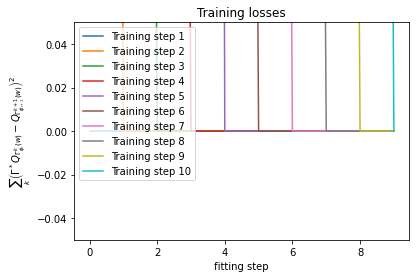

In [39]:
for training_step in range(0, training_steps):
    plt.plot(l2_losses[training_step], label=f"Training step {training_step + 1}")

plt.legend()
plt.ylim(0, max(l2_losses[0]))
plt.xlabel("fitting step")
plt.ylabel(r"$\sum_{k} \left(\Gamma^*Q_{\Gamma_{\phi_i}^k(w)} - Q_{\Gamma_{\phi_{i + 1}}^{k + 1}(w)} \right)^2$")
plt.title("Training losses")
plt.show()

In [58]:
q_weight = validation_initial_weight
for _ in range(max_bellman_iterations):
    q_weight = pbo(pbo.params, q_weight)
q.params = q.to_params(q_weight)

# q.params = q.to_params(pbo.fixed_point(pbo.params))


env.simulate(q, horizon, jnp.array([-0.5, 0]))

[-0.5  0. ]
[-0.3225807]
[-0.51208484]

[-0.5196691 -0.3866922]
[-0.08661258]
[-0.4829303]

[-0.57458174 -0.69058496]
[0.13617855]
[-0.41740727]

[-0.6524237  -0.83584255]
[0.30957687]
[-0.37386394]

[-0.73584473 -0.8066418 ]
[0.40311736]
[-0.3848462]

[-0.80970716 -0.6561602 ]
[0.38864774]
[-0.4331876]

[-0.86512876 -0.44623235]
[0.2655896]
[-0.50151515]

[-0.8982154  -0.21346611]
[0.06338322]
[-0.5799229]

[-0.9076059  0.0260565]
[-0.17048126]
[-0.652246]

[-0.8930263  0.2648832]
[-0.3865322]
[-0.69823956]

[-0.8549221   0.49457222]
[-0.55749094]
[-0.7050581]

[-0.7950392  0.6956501]
[-0.67465115]
[-0.67336106]

[-0.6857938  1.4989254]
[-0.81392753]
[-0.56519854]

[-0.49860302  2.1752536 ]
[-0.60165656]
[-0.48283255]

[-0.27590668  2.1455553 ]
[-0.44525182]
[-0.4033481]

[-0.08456759  1.660017  ]
[-0.4412378]
[-0.36836803]

[0.05863285 1.2697309 ]
[-0.37997925]
[-0.31767285]

[0.17655253 1.1034458 ]
[-0.26295412]
[-0.24543738]

[0.28163967 1.0094086 ]
[-0.13771379]
[-0.15996146]

[0.

DeviceArray([ True], dtype=bool)

In [14]:
# training_losses = np.zeros(max_bellman_iterations_validation)
# validation_losses = np.zeros(max_bellman_iterations_validation)
# absording_probabilities = np.zeros((max_bellman_iterations_validation, horizon))

# batch_iterated_weights = validation_initial_weight.reshape((1, -1))
# for bellman_iteration in range(max_bellman_iterations_validation):
#     q_i = q.discretize(batch_iterated_weights, states, actions)[0]
#     batch_iterated_weights = pbo(pbo.params, batch_iterated_weights)
#     q_i_plus_1 = q.discretize(batch_iterated_weights, states, actions)[0]
#     policy_q = q_i_plus_1.argmax(axis=1)

#     training_losses[bellman_iteration] = jnp.abs(env.apply_bellman_operator(q_i) - q_i_plus_1).mean()
#     validation_losses[bellman_iteration] = jnp.abs(optimal_q - q_i_plus_1).mean()
#     absording_probabilities[bellman_iteration] = env.absorbing_probability(policy_q, horizon)

#     print(policy_q)

## Visualize errors in Q functions

In [15]:
import matplotlib.pyplot as plt 

iterations = range(1, max_bellman_iterations_validation + 1)

plt.plot(iterations, validation_losses, label="pbo linear", color="green")
plt.plot(iterations, validation_losses_tabular, label="pbo max-linear", color="grey", linestyle="--")
plt.plot(iterations, validation_losses_optimal, label="pbo optimal", color="black")
plt.plot(range(1, max_bellman_iterations + 1), validation_losses_q, label="FQI", color="red", linewidth=4)
plt.vlines(max_bellman_iterations, 0, np.max(validation_losses_q), color="black", linestyle="--")

plt.xticks(iterations)
plt.xlabel("iterations")

plt.title(r"$|| Q^* - Q_i ||_1$")
_ = plt.legend()

NameError: name 'validation_losses' is not defined

In [ ]:
plt.plot(iterations, training_losses, label="pbo linear", color="green")
plt.plot(iterations, training_losses_tabular, label="pbo max-linear", color="grey")
plt.plot(iterations, training_losses_optimal, label="pbo optimal", color="black")
plt.plot(range(1, max_bellman_iterations + 1), training_losses_q, label="FQI", color="red")
plt.vlines(max_bellman_iterations, 0, np.maximum(np.max(training_losses_q), np.max(training_losses)), color="black", linestyle="--")

plt.xticks(iterations)
plt.xlabel("iterations")

plt.title(r"$|| \Gamma^*Q_{i-1} - Q_i ||_1$")
_ = plt.legend()

## Understanding the learning process

In [ ]:
empirical_transition_proba = np.zeros((n_states, n_states * n_actions))

for idx_sample in range(len(replay_buffer.states)):
    state = replay_buffer.states[idx_sample, 0]
    action = replay_buffer.actions[idx_sample, 0]
    next_state = replay_buffer.next_states[idx_sample, 0]

    empirical_transition_proba[next_state, state * n_actions + action] += 1 

empirical_transition_proba /= n_repetitions


In [ ]:
np.linalg.norm(empirical_transition_proba - pbo_tabular.params["TabularPBONet/linear"]["w"] / gamma)

## Visualize errors in preformances

In [ ]:
iteration = 5
time = range(1, horizon + 1)


plt.plot(time, absording_probabilities[iteration], label="pbo linear", color="green")
plt.plot(time, absording_probabilities_tabular[iteration], label="pbo max-linear", color="grey", linestyle="--")
plt.plot(time, absording_probabilities_optimal[iteration], label="pbo optimal", color="black")
plt.plot(time, absording_probabilities_q[min([iteration, max_bellman_iterations - 1])], label="FQI", color="red")

plt.xticks(time)
plt.xlabel("time")

plt.title(r"$P^{\pi}(s_i =$ absorbing state)")
_ = plt.legend()

In [ ]:
iteration = 1


plt.plot(iterations, absording_probabilities[:, -1], label="pbo linear", color="green")
plt.plot(iterations, absording_probabilities_tabular[:, -1], label="pbo max-linear", color="grey", linestyle="--")
plt.plot(iterations, absording_probabilities_optimal[:, -1], label="pbo optimal", color="black")
plt.plot(range(1, max_bellman_iterations + 1), absording_probabilities_q[:, -1], label="FQI", color="red")
plt.vlines(max_bellman_iterations, 0, 1, color="black", linestyle="--")

plt.xticks(iterations)
plt.xlabel("iterations")

plt.title(r"$P^{\pi}(s_i =$ absorbing state)" + f" after {horizon} steps")
_ = plt.legend()